In [1]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from tensorflow.python.util import deprecation
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd
import glob
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

/home/bigcloud/anaconda3/envs/hyunsoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bigcloud/anaconda3/envs/hyunsoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bigcloud/anaconda3/envs/hyunsoo/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bigcloud/anaconda3/envs/hyunsoo

In [2]:
deprecation._PRINT_DEPRECATION_WARNINGS = False
DATA_DIR = 'input'
ROOT_DIR = '.'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
train_dicom_dir = os.path.join(DATA_DIR, 'stage_2_train_images')
test_dicom_dir = os.path.join(DATA_DIR, 'stage_2_test_images')

COCO_WEIGHTS_PATH = "reset.h5"

In [3]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

def parse_dataset(dicom_dir, anns):
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows():
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations

# The following parameters have been selected to reduce running time for demonstration purposes
# These are not optimal


In [4]:
class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """

    # Give the configuration a recognizable name
    NAME = 'pneumonia'

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1 #you can change this value for your computer environment
    IMAGES_PER_GPU = 8

    BACKBONE = 'resnet50'

    NUM_CLASSES = 2  # background + 1 pneumonia classes

    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    RPN_ANCHOR_SCALES = (32, 64, 128, 256)
    TRAIN_ROIS_PER_IMAGE = 8
    MAX_GT_INSTANCES = 3 # 4 -> 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.8
    DETECTION_NMS_THRESHOLD = 0.15

    STEPS_PER_EPOCH = 1000
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.15
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE               

In [5]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)

        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')

        # add images
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp,
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

24184 2500
(1024, 1024, 3)
input/stage_2_train_images/b79d126e-d469-4dc1-82e8-b3167e6b52d3.dcm
[1 1]


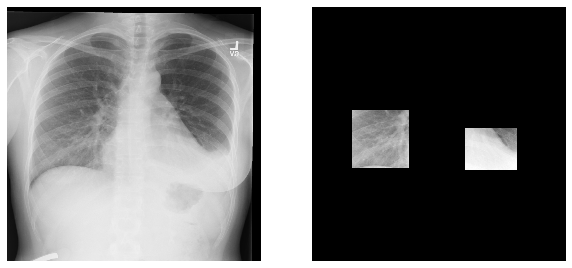

In [6]:
anns = pd.read_csv(os.path.join(DATA_DIR, 'stage_2_train_labels.csv'))
image_fps, image_annotations = parse_dataset(train_dicom_dir, anns=anns)
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath
image = ds.pixel_array # get image array
# Original DICOM image size: 1024 x 1024
ORIG_SIZE = 1024

# split dataset into training vs. validation dataset
# split ratio is set to 0.9 vs. 0.1 (train vs. validation, respectively)
image_fps_list = list(image_fps)
random.seed(42)
random.shuffle(image_fps_list)

val_size = 2500
image_fps_val = image_fps_list[:val_size]
image_fps_train = image_fps_list[val_size:]

print(len(image_fps_train), len(image_fps_val))

# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_train.prepare()

# Show annotation(s) for a DICOM image
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, ORIG_SIZE, ORIG_SIZE)
dataset_val.prepare()
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_train.image_ids)
    image_fp = dataset_train.image_reference(image_id)
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

In [7]:
# Image augmentation (light but constant)
augmentation = iaa.Sequential([
    iaa.OneOf([ ## geometric transform
        iaa.Affine(
            scale={"x": (0.98, 1.02), "y": (0.98, 1.02)},
            translate_percent={"x": (-0.02, 0.02), "y": (-0.04, 0.04)},
            rotate=(-2, 2),
            shear=(-1, 1),
        ),
        iaa.PiecewiseAffine(scale=(0.001, 0.025)),
    ]),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])

/home/bigcloud/anaconda3/envs/hyunsoo/lib/python3.6/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)











Starting at epoch 0. LR=0.00030000000000000003

Checkpoint Path: ./pneumonia20200604T1210/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

1000/1000 [==============================] - 2363s 2s/step - loss: 0.9792 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.1358 - mrcnn_bbox_loss: 0.2837 - mrcnn_mask_loss: 0.3496 - val_loss: 1.2694 - val_rpn_class_loss: 0.0066 - val_rpn_bbox_loss: 0.2726 - val_mrcnn_class_loss: 0.1712 - val_mrcnn_bbox_loss: 0.4127 - val_mrcnn_mask_loss: 0.4062
Epoch 5/15
1000/1000 [==============================] - 2306s 2s/step - loss: 0.9412 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.1292 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.3417 - val_loss: 1.2424 - val_rpn_class_loss: 0.0096 - val_rpn_bbox_loss: 0.2709 - val_mrcnn_class_loss: 0.1566 - val_mrcnn_bbox_loss: 0.4078 - val_mrcnn_mask_loss: 0.3975
Epoch 6/15
1000/1000 [==============================] - 2162s 2s/step - loss: 0.9133 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1928 - mrcnn_class_loss: 0.1215 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.3297 - val_loss: 1.3138 - val_rpn_class_los

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,1.224967,0.009343,0.270093,0.190027,0.380781,0.374715,1.164025,0.008977,0.245552,0.186533,0.350275,0.372680
2,1.520907,0.014764,0.502293,0.217141,0.394411,0.392290,1.038932,0.007964,0.214899,0.156974,0.306479,0.352609
3,1.392621,0.008862,0.389946,0.175213,0.397033,0.421560,0.996697,0.007424,0.205155,0.145169,0.291662,0.347278
4,1.269375,0.006641,0.272578,0.171242,0.412697,0.406209,0.979240,0.006659,0.203541,0.135793,0.283664,0.349575
5,1.242382,0.009562,0.270913,0.156576,0.407783,0.397540,0.941220,0.006732,0.191112,0.129158,0.272513,0.341696
6,1.313795,0.014674,0.409739,0.140295,0.362610,0.386469,0.913348,0.006809,0.192832,0.121520,0.262436,0.329742
7,1.450721,0.011807,0.488281,0.111466,0.405234,0.433926,0.884745,0.006632,0.183250,0.114689,0.255276,0.324891
8,1.318715,0.009725,0.310072,0.162757,0.427942,0.408212,0.889675,0.006870,0.187205,0.119676,0.250356,0.325559
9,1.561445,0.014291,0.391613,0.233511,0.453836,0.468187,0.839129,0.005274,0.167365,0.116878,0.231154,0.318449
10,1.361620,0.011830,0.364787,0.183981,0.385175,0.415839,0.810960,0.005351,0.160039,0.107522,0.224235,0.313804


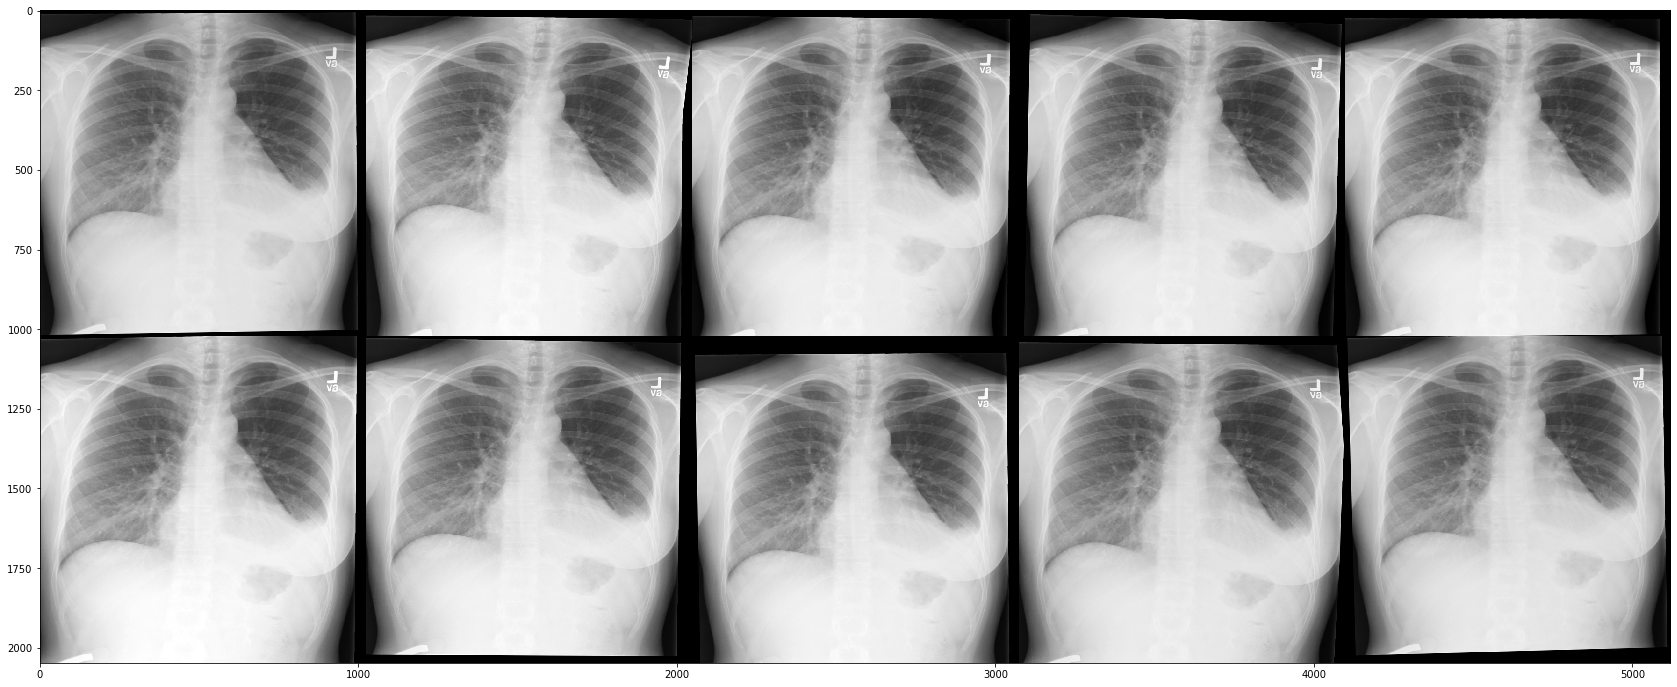

In [8]:
# test on the same image as above
imggrid = augmentation.draw_grid(image[:, :, 0], cols=5, rows=2)
plt.figure(figsize=(30, 12))
_ = plt.imshow(imggrid[:, :, 0], cmap='gray')

model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])

LEARNING_RATE = 0.003

# Train Mask-RCNN Model
import warnings
warnings.filterwarnings("ignore")


## train heads with higher lr to speedup the learning
"""model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet
history = model.keras_model.history.history

model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=7,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]
    
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/5,
            epochs=15,
            layers='all',
            augmentation=augmentation)

new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]
"""
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/10,
            epochs=15,
            layers='all',
            augmentation=augmentation)
history = model.keras_model.history.history

epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

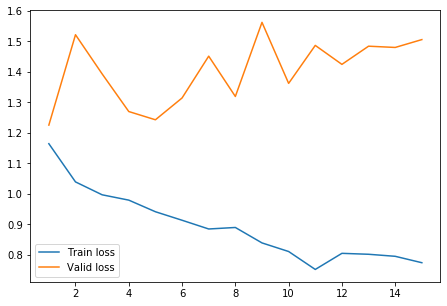

In [9]:
plt.figure(figsize=(25,5))
plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()

plt.show()

In [10]:
# select trained model
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
     import errno
     raise FileNotFoundError(errno.ENOENT,"Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names:
	dir_name = os.path.join(model.model_dir, d)
	checkpoints = next(os.walk(dir_name))[2]
	checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
	checkpoints = sorted(checkpoints)
	if not checkpoints:
		print('No Weight Files in {}'.format(dir_name))
	else:
		checkpoint = os.path.join(dir_name, checkpoints[-1])
		fps.append(checkpoint)
model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model ./pneumonia20200604T1210/mask_rcnn_pneumonia_0015.h5



Loading weights from  ./pneumonia20200604T1210/mask_rcnn_pneumonia_0015.h5
Re-starting from epoch 15
(512, 512, 3)
(512, 512, 3)
(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)

*** No instances to display *** 

(512, 512, 3)
(512, 512, 3)

*** No instances to display *** 



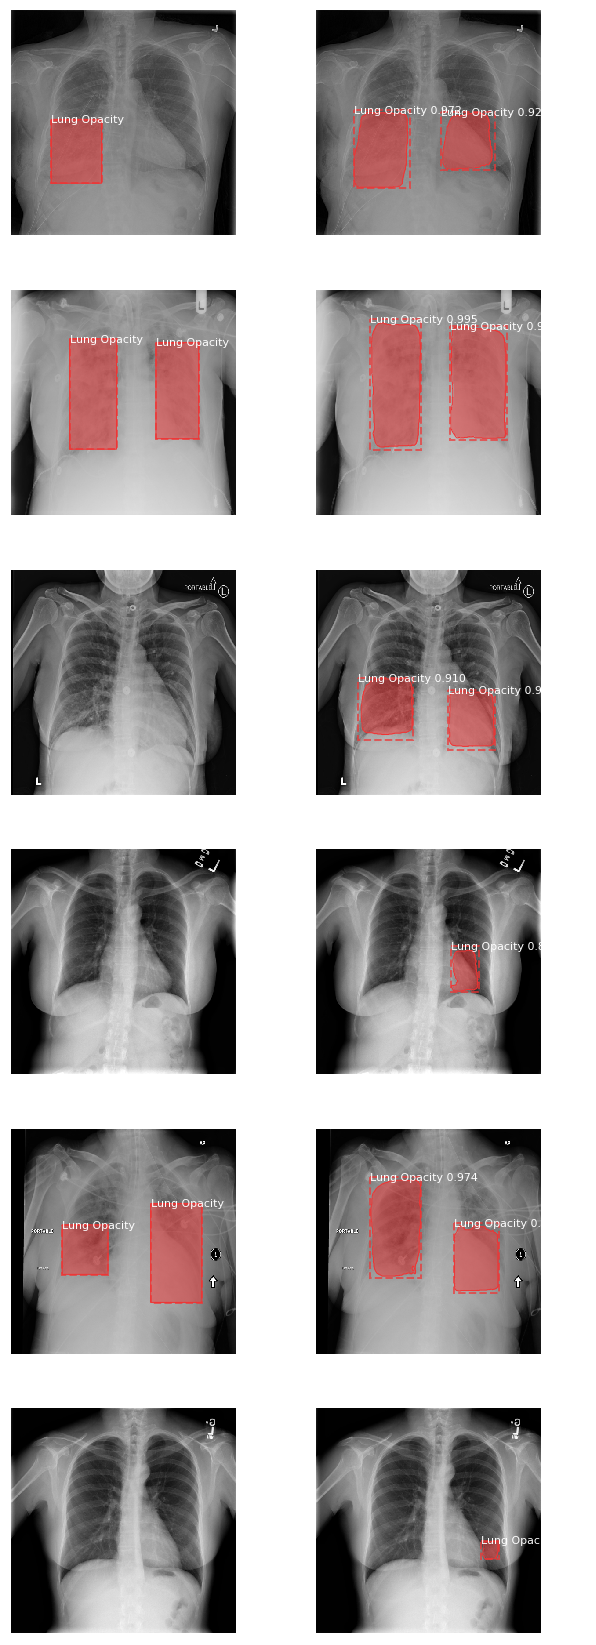

In [11]:
class InferenceConfig(DetectorConfig):
        GPU_COUNT = 1
        IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference',
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors

# Show few example of ground truth vs. predictions on the validation dataset
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(6):

    image_id = random.choice(dataset.image_ids)

    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)

    print(original_image.shape)
    plt.subplot(6, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])

    plt.subplot(6, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                                dataset.class_names, r['scores'],
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

# Get filenames of test dataset DICOM images
test_image_fps = get_dicom_fps(test_dicom_dir)


In [12]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=0.95):
    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("patientId,PredictionString\n")

        for image_id in tqdm(image_fps):
            ds = pydicom.read_file(image_id)
            image = ds.pixel_array
            # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                image = np.stack((image,) * 3, -1)
            image, window, scale, padding, crop = utils.resize_image(
                image,
                min_dim=config.IMAGE_MIN_DIM,
                min_scale=config.IMAGE_MIN_SCALE,
                max_dim=config.IMAGE_MAX_DIM,
                mode=config.IMAGE_RESIZE_MODE)

            patient_id = os.path.splitext(os.path.basename(image_id))[0]

            results = model.detect([image])
            r = results[0]

            out_str = ""
            out_str += patient_id
            out_str += ","
            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
                        out_str += ' '
                        out_str += str(round(r['scores'][i], 2))
                        out_str += ' '

                        # x1, y1, width, height
                        x1 = r['rois'][i][1]
                        y1 = r['rois'][i][0]
                        width = r['rois'][i][3] - x1
                        height = r['rois'][i][2] - y1
                        bboxes_str = "{} {} {} {}".format(x1*resize_factor, y1*resize_factor, \
                                                           width*resize_factor, height*resize_factor)
                        out_str += bboxes_str

            file.write(out_str+"\n")

submission_fp = os.path.join(ROOT_DIR, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

output = pd.read_csv(submission_fp, names=['patientId', 'PredictionString'])
output.head(60)

100%|██████████| 3000/3000 [07:04<00:00,  7.07it/s]

./submission.csv


,patientId,PredictionString
0,patientId,PredictionString
1,1d4413e5-f7e4-4835-9b10-53a74aaae5c2,NaN
2,1b7ce0fc-9efb-4960-a207-023bf6039352,0.99 516.0 76.0 158.0 156.0
3,1d73dd5c-4fb7-4684-a64e-14f1bdbec9dc,NaN
4,0e9a0009-4464-4f18-bff5-8dae9645ae6a,0.95 604.0 472.0 172.0 126.0
5,2ac2f354-ae86-4c87-9ed7-38c842c6e604,NaN
6,c19eb270-ac17-48f3-bc22-9ba6fd38ac52,0.98 498.0 440.0 248.0 312.0
7,1a6d0d55-8031-4e17-8c1c-d2023eb0a99e,0.98 562.0 480.0 284.0 268.0 0.96 52.0 548.0 ...
8,27bfde5e-6542-424d-b772-f92e99e22faa,0.99 158.0 682.0 232.0 194.0
9,1c0714ff-9788-455c-91eb-3adabd5d0ca1,0.95 268.0 432.0 156.0 170.0


11efea2c-2129-432f-8478-7877d3b5952d
[239 327 320 408]
x 654 y 478 h 162 w 162
[194  79 273 170]
x 158 y 388 h 182 w 158
2e3f9604-6f57-4332-90cf-5aae2081e36d
[217 282 285 369]
x 564 y 434 h 174 w 136
1b8b82ad-d820-4400-96ae-6da8eb78e90f
[244  74 352 200]
x 148 y 488 h 252 w 216
278800cb-2add-4fd3-83da-144b126a455d
[355 292 432 422]
x 584 y 710 h 260 w 154
[180 289 218 327]
x 578 y 360 h 76 w 76


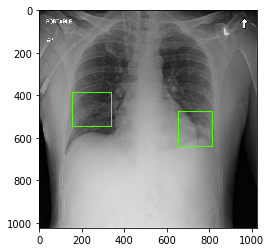

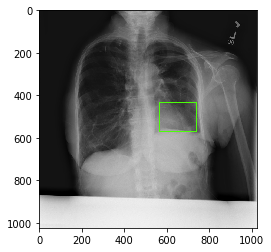

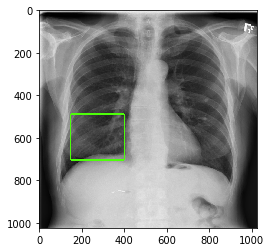

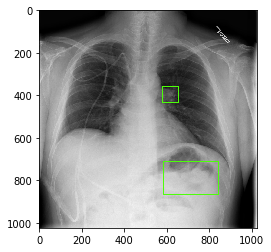

In [13]:
###### show a few test image detection example
def visualize():
    image_id = random.choice(test_image_fps)
    ds = pydicom.read_file(image_id)

    # original image
    image = ds.pixel_array

    # assume square image
    resize_factor = ORIG_SIZE / config.IMAGE_SHAPE[0]

    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1)
    resized_image, window, scale, padding, crop = utils.resize_image(
        image,
        min_dim=config.IMAGE_MIN_DIM,
        min_scale=config.IMAGE_MIN_SCALE,
        max_dim=config.IMAGE_MAX_DIM,
        mode=config.IMAGE_RESIZE_MODE)

    patient_id = os.path.splitext(os.path.basename(image_id))[0]
    print(patient_id)

    results = model.detect([resized_image])
    r = results[0]
    for bbox in r['rois']:
        print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1
        height = y2 - y1
        print("x {} y {} h {} w {}".format(x1, y1, width, height))
    plt.figure()
    plt.imshow(image, cmap=plt.cm.gist_gray)

visualize()
visualize()
visualize()
visualize()